In [1]:
import praw
import pandas as pd
import numpy as np
import pprint
import time
import requests
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup


In [23]:
def load_dataframe():
    
    # load dataframe 
    df = pd.read_csv('D:\\Datafiles\\train.csv', quotechar = '"')
    print('File found')
    return df
        
def make_dataframe():
    
    # create new dataframe
    data = {'label' : [], 'fake' : [], 'bias' : [], 'response' : []}
    df = pd.DataFrame(data=data)
    return df

def get_data(df_fake, url, url2, i, df, data):
    
    # try to get a response form the api
    try:
        response = requests.get(url).json()
        
        # save responses
        fake = response['robot']['fake_news']
        bias = response['robot']['extremely_biased']
        label = df.loc[i].label
        
        # get response from second api
        api2 = requests.post(url2, data=data).json()
        
        # add responses to dataframe
        data_pd = {'label':label, 'fake':fake, 'bias':bias, 'response': api2['content']['decision']}
        return pd.concat([df_fake, pd.DataFrame(data_pd, index=[i])])
    except:
        return df_fake
    
def clean(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html)

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text


In [24]:
def run():
    # eerste api
    BASE = ['https://api.fakenewsdetector.org//votes_by_content?content=']
    
    # tweede api
    BASE2 = 'http://localhost:8080/fakebox/check'
    
    # load dataframe to check, and make dataframe to save 
    df = load_dataframe()
    df_fake = make_dataframe()
    data = {"url": '',
            "title": '',
            "content": ''}

    # for the first 1500 datapoints, send to api and save responses
    for i in range(1500):
        try:
            
            # make url, and add content to data
            url = BASE[0] + df.loc[i].text
            data['content'] = df.loc[i].text
            
            # get responses
            df_fake = get_data(df_fake, url, BASE2, i, df, data)

        except:
            
            # print text to debug if things go wrong
            print(df.loc[i].text)
    
    # save results to .csv
    df_fake.to_csv('recall.csv', index=False, header=True)


In [24]:
def recall_precision():
    
    # load checked dataframe
    df_fake = pd.read_csv('recall.csv')
    
    # set checking and saving variables
    best = 0
    thresh = 0
    temp = []
    temp1 = []
    recall = []
    precision = []
    
    # for every threshold percentage check the precision and recall
    for i in range(100):
        threshold = (i+1)/100
        
        # try to calculate precision and recall
        try:
            
            # for second api
            prec = len(df_fake[(df_fake.response != 'impartial') & (df_fake.label == 1)]) / len(df_fake[df_fake.response != 'impartial'])
            rec = len(df_fake[(df_fake.response != 'impartial') &(df_fake.label == 1)]) / len(df_fake[df_fake.label == 1])
            
            # calculate f1 score
            f1 = 2 * (prec * rec)/(prec + rec)
            
            # add all values to respective lists
            temp.append(f1)
            temp1.append(i+1)
            recall.append(rec)
            precision.append(prec)
            
            # check for best
            if f1 > best:
                thresh = i + 1
                best = f1
        except:
            pass
        
    # print output and make a plot
    print(f'best recall: {recall[thresh - 1]}, best precision: {precision[thresh - 1]}, best f1 {best}')
    plt.plot(temp1,temp, color='blue')
    plt.plot(temp1, recall, color='green')
    plt.plot(temp1, precision, color='red')

best recall: 0.8543516873889876, best precision: 0.5967741935483871, best 0.7027027027027026


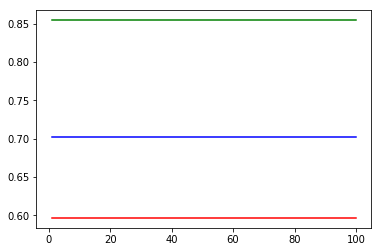

In [25]:
#run()
recall_precision()

In [39]:
df_fake = pd.read_csv('recall.csv')

best = 0
best_thresh = 0
for i in range(100):
    temp = len(df_fake[(df_fake.fake > (i+1)/100) & (df_fake.response == 'bias')])
    if temp > best:
        best = temp
        best_thresh = (i+1)/100
        
    print(temp, (i+1)/100)
best, best_thresh

598 0.01
597 0.02
595 0.03
591 0.04
586 0.05
577 0.06
571 0.07
563 0.08
551 0.09
538 0.1
529 0.11
514 0.12
489 0.13
474 0.14
457 0.15
441 0.16
429 0.17
412 0.18
399 0.19
380 0.2
361 0.21
350 0.22
338 0.23
323 0.24
313 0.25
297 0.26
290 0.27
286 0.28
275 0.29
266 0.3
254 0.31
241 0.32
232 0.33
214 0.34
200 0.35
195 0.36
184 0.37
175 0.38
166 0.39
160 0.4
149 0.41
144 0.42
137 0.43
127 0.44
122 0.45
115 0.46
108 0.47
100 0.48
93 0.49
87 0.5
81 0.51
78 0.52
75 0.53
62 0.54
62 0.55
54 0.56
48 0.57
47 0.58
46 0.59
38 0.6
35 0.61
31 0.62
28 0.63
26 0.64
25 0.65
23 0.66
22 0.67
18 0.68
17 0.69
16 0.7
15 0.71
14 0.72
14 0.73
13 0.74
12 0.75
11 0.76
11 0.77
11 0.78
11 0.79
8 0.8
7 0.81
6 0.82
5 0.83
3 0.84
3 0.85
3 0.86
2 0.87
1 0.88
1 0.89
1 0.9
1 0.91
1 0.92
1 0.93
1 0.94
0 0.95
0 0.96
0 0.97
0 0.98
0 0.99
0 1.0


(598, 0.01)